In [ ]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 168 kB/s 


In [ ]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install imageio_ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 827 kB/s 


In [ ]:
import os
import pygame
from gym.envs.toy_text.frozen_lake import generate_random_map
import gym
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.display.set_mode((800, 600))

pygame 2.1.0 (SDL 2.0.16, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(800x600x32 SW)>

In [ ]:
def plot_epsilon(epsilon):
    steps = np.arange(0, len(epsilon), 1)
    plt.clf()
    # plt.gcf().set_size_inches((7, 7))
    plt.plot(steps, epsilon, marker="o", markersize=1)
    plt.ylabel("Epsilon ")
    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rewards(rewards, episodes, mult = 1):
    # Plot reward per 1000 episodes
    # Line plot to show how average reward changes over time
    average_rewards = np.split(np.array(rewards), episodes/mult)
    steps = mult * np.arange(len(average_rewards))
    plt.clf()
    plt.plot(steps, np.average(average_rewards, 1))
    plt.ylabel("Average Reward")
    plt.xlabel("Episode")
    plt.tight_layout()
    plt.show()

In [ ]:
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", new_step_api=True, is_slippery=True)

In [ ]:
import random
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

exploration_rate_tracker = []

def build_nn(num_acts, num_states=1, lr=0.001):
    model = Sequential([Dense(256, input_shape=(num_states,)),
                        Activation("relu"),
                        Dense(num_acts)])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


class Buffer:
    curr_state = []
    next_state = []
    action = []
    reward = []
    done = []
    
    def save(action, curr_state, next_state, reward, done):
        Buffer.action.append(action)
        Buffer.curr_state.append(curr_state)
        Buffer.next_state.append(next_state)
        Buffer.reward.append(reward)
        Buffer.done.append(done)

    def get_sample(num_sample=20):
        ids = random.sample(range(0, len(Buffer.action) - 1), num_sample)
        
        action = []
        curr_state = []
        next_state = []
        reward = []
        done = []
        
        for i in random.sample(range(0, len(Buffer.action) - 1), num_sample):
            action.append(Buffer.action[i])
            curr_state.append(Buffer.curr_state[i])
            next_state.append(Buffer.next_state[i])
            reward.append(Buffer.reward[i])
            done.append(Buffer.done[i])
            
        return action, curr_state, next_state, reward, done


class Agent:
    def __init__(self, num_acts):
        self.num_acts = num_acts
        # self.exploration_rate = .99      # eps
        # self.exploration_decay_rate = 0.999  # eps decay
        # self.min_exploration_rate = .001   # eps min
        self.discount_rate= .95      # discount factor
        
        self.exploration_rate = 1
        self.max_exploration_rate = 1
        self.min_exploration_rate = 0.001
        self.exploration_decay_rate = 0.0005
        
        self.eval_nn = build_nn(num_acts)
        self.target_nn = build_nn(num_acts)
        

    def choose(self, state):
        if random.random() < self.exploration_rate:
            return random.randint(0, self.num_acts - 1)
        
        return np.argmax(self.eval_nn.predict(np.array([state]), verbose=0))

    def learn(self, batch_size=69, game_num=0):
        buff_len = len(Buffer.action)
        if batch_size < buff_len:
            action, \
            curr_state, \
            next_state, \
            reward, \
            done = Buffer.get_sample()
            
            eval_q = self.eval_nn.predict(np.array(next_state), verbose=0)
            next_q = self.target_nn.predict(np.array(next_state), verbose=0)
            target_q = self.target_nn.predict(np.array(curr_state), verbose=0)

            for i in range(len(target_q)):
                max_i = np.argmax(eval_q[i])
                term = 1 - done[i]
                target_q[i][action[i]] = reward[i] + self.discount_rate * next_q[i][max_i] * term

            self.eval_nn.fit(np.array(curr_state), target_q, verbose=0)
            
            if buff_len % 100 == 0:
                self.target_nn.set_weights(self.eval_nn.get_weights())
            
            self.exploration_rate =  self.min_exploration_rate + \
                (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*game_num)
            exploration_rate_tracker.append(self.exploration_rate)


def main(num_games=10000, max_steps=800, mult = 1000):
    agent = Agent(env.action_space.n)
    rewards_all_episodes = []
    
    wins = 0.0
    for i in range(num_games):
        print("Game:", i, "Wins:", wins)
        done = False
        curr_state = env.reset()
        steps = 0
        tot_reward = 0
        while not done:
            if steps > max_steps:
                raise Exception("Too many steps")
            steps += 1
        
            act = agent.choose(curr_state)
            next_state, reward, done, truncated, info = env.step(act)

            wins += reward
            
            if not done and reward == 0 and next_state != curr_state:
              reward = 0.1 * next_state/100
            if done and reward == 0:
              reward = -0.1 * next_state/100
            if done and reward == 1.0:
              reward = 20

            done = done
            tot_reward += reward

            temp_reward = reward
            Buffer.save(act, curr_state, next_state, reward, done)
            agent.learn(69, i)
        rewards_all_episodes.append(tot_reward)
    print("Score over time: " +  str(sum(rewards_all_episodes)/num_games))
    save_model(agent)
    plot_epsilon(exploration_rate_tracker)
    plot_rewards(rewards_all_episodes, num_games, mult)
    # plot_temp_rewards(rewards_all_episodes, num_games, mult)
    
def save_model(agent):
    agent.eval_nn.save("model.h5")
    agent.target_nn.save("model.h5")

def fetch_model():
    agent = Agent(4)
    agent.eval_nn = load_model("model.h5")
    agent.target_nn = load_model("model.h5")
    return agent

def run_model():
    random_map = generate_random_map(size=10, p=0.3)
    env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", desc=random_map)
    agent = fetch_model()
    
    # Run for ten games
    
    tot_reward = wins = 0
    for i in range(11):
        print("Game:", i, "Wins:", wins)
        done = False
        curr_state = env.reset()
        env.render()
        steps = 0
        while not done:
            if steps > 99:
                raise Exception("Too many steps")
            steps += 1
        
            act = agent.choose(curr_state)
            next_state, reward, done, truncated, info = env.step(act)
            wins += reward
            done = done
            env.render()
            curr_state = next_state

Streaming output truncated to the last 5000 lines.
Game: 5001 Wins: 0.0
Game: 5002 Wins: 0.0
Game: 5003 Wins: 0.0
Game: 5004 Wins: 0.0
Game: 5005 Wins: 0.0
Game: 5006 Wins: 0.0
Game: 5007 Wins: 0.0
Game: 5008 Wins: 0.0
Game: 5009 Wins: 0.0
Game: 5010 Wins: 0.0
Game: 5011 Wins: 0.0
Game: 5012 Wins: 0.0
Game: 5013 Wins: 0.0
Game: 5014 Wins: 0.0
Game: 5015 Wins: 0.0
Game: 5016 Wins: 0.0
Game: 5017 Wins: 0.0
Game: 5018 Wins: 0.0
Game: 5019 Wins: 0.0
Game: 5020 Wins: 0.0
Game: 5021 Wins: 0.0
Game: 5022 Wins: 0.0
Game: 5023 Wins: 0.0
Game: 5024 Wins: 0.0
Game: 5025 Wins: 0.0
Game: 5026 Wins: 0.0
Game: 5027 Wins: 0.0
Game: 5028 Wins: 0.0
Game: 5029 Wins: 0.0
Game: 5030 Wins: 0.0
Game: 5031 Wins: 0.0
Game: 5032 Wins: 0.0
Game: 5033 Wins: 0.0
Game: 5034 Wins: 0.0
Game: 5035 Wins: 0.0
Game: 5036 Wins: 0.0
Game: 5037 Wins: 0.0
Game: 5038 Wins: 0.0
Game: 5039 Wins: 0.0
Game: 5040 Wins: 0.0
Game: 5041 Wins: 0.0
Game: 5042 Wins: 0.0
Game: 5043 Wins: 0.0
Game: 5044 Wins: 0.0
Game: 5045 Wins: 0.0
Game

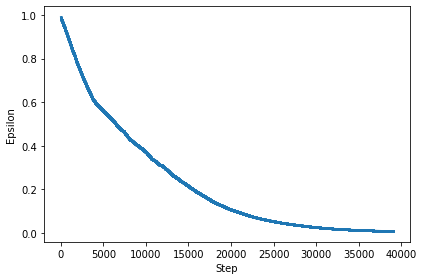

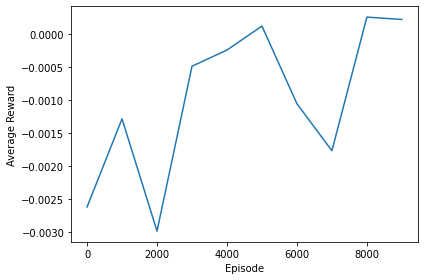

In [ ]:
main()

In [ ]:
import imageio
import base64
import pygame
import os
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return HTML(tag)

In [ ]:
def create_policy_eval_video(filename, num_episodes=100, fps=5):
  filename = filename + ".mp4"
  agent = fetch_model()
  wins = 0.0
  # eval_py_env = make_env()
  with imageio.get_writer(filename, fps=fps) as video:
    for i in range(num_episodes):
        print("Game:", i, "Wins:", wins)
        done = False
        curr_state = env.reset()
        start = np.array(env.render())
        start = np.array(start).reshape((512,512, 3))
        video.append_data(start)
        steps = 0
        while not done:
            if steps > 800:
                raise Exception("Too many steps")
            steps += 1
        
            act = agent.choose(curr_state)
            next_state, reward, done, truncated, tr = env.step(act)
            wins += reward
            end = np.array(env.render())
            end = np.array(end).reshape((512,512, 3))
            curr_state = next_state
            video.append_data(end)
  return embed_mp4(filename)

create_policy_eval_video("trained-agent")

Game: 0 Wins: 0.0
Game: 1 Wins: 0.0
Game: 2 Wins: 0.0
Game: 3 Wins: 0.0
Game: 4 Wins: 0.0
Game: 5 Wins: 0.0
Game: 6 Wins: 0.0
Game: 7 Wins: 0.0
Game: 8 Wins: 0.0
Game: 9 Wins: 0.0
Game: 10 Wins: 0.0
Game: 11 Wins: 0.0
Game: 12 Wins: 0.0
Game: 13 Wins: 0.0
Game: 14 Wins: 0.0
Game: 15 Wins: 0.0
Game: 16 Wins: 0.0
Game: 17 Wins: 0.0
Game: 18 Wins: 0.0
Game: 19 Wins: 0.0
Game: 20 Wins: 0.0
Game: 21 Wins: 0.0
Game: 22 Wins: 0.0
Game: 23 Wins: 0.0
Game: 24 Wins: 0.0
Game: 25 Wins: 0.0
Game: 26 Wins: 0.0
Game: 27 Wins: 0.0
Game: 28 Wins: 0.0
Game: 29 Wins: 0.0
Game: 30 Wins: 0.0
Game: 31 Wins: 0.0
Game: 32 Wins: 0.0
Game: 33 Wins: 0.0
Game: 34 Wins: 0.0
Game: 35 Wins: 0.0
Game: 36 Wins: 0.0
Game: 37 Wins: 0.0
Game: 38 Wins: 0.0
Game: 39 Wins: 0.0
Game: 40 Wins: 0.0
Game: 41 Wins: 0.0
Game: 42 Wins: 0.0
Game: 43 Wins: 0.0
Game: 44 Wins: 0.0
Game: 45 Wins: 0.0
Game: 46 Wins: 0.0
Game: 47 Wins: 0.0
Game: 48 Wins: 0.0
Game: 49 Wins: 0.0
Game: 50 Wins: 0.0
Game: 51 Wins: 0.0
Game: 52 Wins: 0.0
Gam